In [1]:
%%bash
cd egtr/lib/fpn/box_intersections_cpu
python setup.py build_ext --inplace

In [5]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from egtr.model.egtr import DetrForSceneGraphGeneration
from egtr.model.deformable_detr import DeformableDetrConfig
import matplotlib.pyplot as plt
from transformers import AutoModel, DeformableDetrForObjectDetection

In [46]:
count_mat = [['cat','cat'].count(i) for i in ['cat','cat']]

In [47]:
count_mat

[2, 2]

In [48]:
import numpy as np
import pandas as pd
import cv2
import torch
from PIL import Image
from egtr.model.egtr import DetrForSceneGraphGeneration
from egtr.model.deformable_detr import DeformableDetrConfig
import matplotlib.pyplot as plt
from transformers import AutoModel, DeformableDetrForObjectDetection, AutoImageProcessor

def batch_to_device(batch,device='cuda'):
    for k in batch:
        batch[k] = batch[k].to(device)
    return batch

class EGTRInfer():
    def __init__(self, cfg_path, ckpt_path, labels, relations, device='cuda'):
        self.config = DeformableDetrConfig.from_json_file(cfg_path)
        self.procc = AutoImageProcessor.from_pretrained('SenseTime/deformable-detr')
        self.model =  DetrForSceneGraphGeneration(config=self.config).to(device)
        self.labels = labels
        self.relations = relations
        self.device = device
        chekpoint = torch.load(ckpt_path)
        state_dict = {}
        for k in chekpoint['state_dict']:
            state_dict[k.replace('model.','',1)] = chekpoint['state_dict'][k]
        self.model.load_state_dict(state_dict)
    
    def index_labels(self,labels):
        new_labels = []
        count_mat = [labels.count(i) for i in labels]
        for i in range(len(labels)):
            if count_mat[i] == 1:
                new_labels.append(labels[i])
            else:
                new_labels.append(f"{labels[i]}_{labels[:i].count(labels[i])}")
        return new_labels
    
    def __call__(self, img_path, threshold=0.5,visual=True,color=(239,239,239)):
        image = Image.open(img_path)
        encodes = self.procc(images=image, return_tensors="pt")
        encodes = batch_to_device(encodes,self.device)
        with torch.no_grad():
            outs = self.model(**encodes,output_attention_states=True, output_hidden_states=True)
            
        target_sizes = torch.tensor([image.size[::-1]])
        results = self.procc.post_process_object_detection(outs, threshold=threshold, target_sizes=target_sizes)[0]
        results['scores'] = results['scores'].cpu().detach().tolist()
        results['boxes'] = results['boxes'].cpu().detach().tolist()
        results['labels'] = [self.labels[i] for i in results['labels']]
        results['labels'] = self.index_labels(results['labels'])
        score2labels = dict(zip(results['scores'], results['labels']))
        
        logits = outs.logits[0].sigmoid()
        probs = logits.max(dim=-1).values
        probs = sorted(enumerate(probs),key=lambda x: -x[1])
        ids = [i for i,p in probs if p > threshold]
        labels2id = dict(zip(ids,range(len(ids))))
        triplets = []
        for i in ids:
            for j in ids:
                if i != j:
                    rel = outs['pred_rel'][0][i][j].argmax(dim=-1).item()
                    triplets.append((results['labels'][labels2id[i]],self.relations[rel],results['labels'][labels2id[j]]))
        results['triplets'] = triplets
        
        if visual:
            sample = cv2.imread(img_path)
            for score,label,box in zip(results['scores'],results['labels'],results['boxes']):
                box = list(map(int,box))
                cv2.rectangle(sample,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    color, 1
                )
    
                cv2.putText(
                    sample,
                    f"{label}:{score:.2f}",
                    (box[0], box[1]),
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 0.6,
                    color = (255, 255, 255),
                    thickness=2
                )
            plt.imshow(sample)
        return results

In [49]:
labels = pd.read_json("vg/val.json",lines=True)['categories'][0]
labels = [row['name'] for row in labels]
rels = pd.read_json('vg/rel.json',lines=True)['rel_categories'][0][1:]

In [50]:
model = EGTRInfer(
    cfg_path='chekpoint/egtr__pretrained_detr__SenseTime__deformable-detr__batch__32__epochs__150_50__lr__1e-05_0.0001__visual_genome__finetune__version_0/batch__64__epochs__50_25__lr__2e-07_2e-06_0.0002__visual_genome__finetune/version_0/config.json',
    ckpt_path='chekpoint/egtr__pretrained_detr__SenseTime__deformable-detr__batch__32__epochs__150_50__lr__1e-05_0.0001__visual_genome__finetune__version_0/batch__64__epochs__50_25__lr__2e-07_2e-06_0.0002__visual_genome__finetune/version_0/checkpoints/epoch=03-validation_loss=1.71.ckpt',
    labels=labels,
    relations=rels,
    device='cuda'
)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


{'scores': [0.5580849051475525,
  0.4639492928981781,
  0.44757646322250366,
  0.4337030351161957,
  0.40403875708580017],
 'labels': ['bear_0', 'bear_1', 'ear', 'head', 'rock'],
 'boxes': [[325.6324768066406,
   173.39479064941406,
   504.30877685546875,
   436.6296691894531],
  [1.25518798828125, 9.688549995422363, 96.94660949707031, 256.7092590332031],
  [396.84442138671875,
   208.91952514648438,
   429.428466796875,
   239.6056365966797],
  [326.9894104003906, 204.0522003173828, 434.3948669433594, 317.3893127441406],
  [165.23129272460938,
   293.88055419921875,
   210.35972595214844,
   327.49920654296875]],
 'triplets': [('bear_0', 'near', 'bear_1'),
  ('bear_0', 'has', 'ear'),
  ('bear_0', 'has', 'head'),
  ('bear_0', 'near', 'rock'),
  ('bear_1', 'looking at', 'bear_0'),
  ('bear_1', 'has', 'ear'),
  ('bear_1', 'has', 'head'),
  ('bear_1', 'standing on', 'rock'),
  ('ear', 'of', 'bear_0'),
  ('ear', 'of', 'bear_1'),
  ('ear', 'on', 'head'),
  ('ear', 'on', 'rock'),
  ('head', 

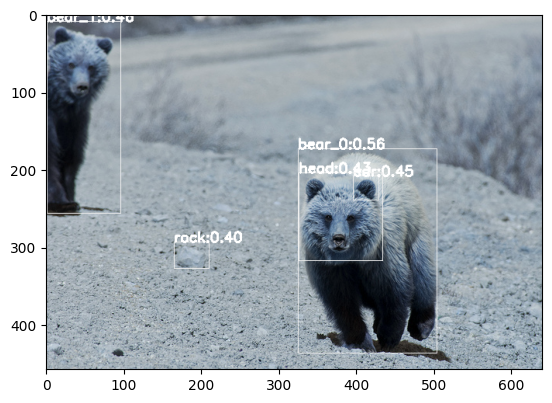

In [57]:
model('000000020247.jpg',threshold=0.4)